### Import libraries

In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import features as ft
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

---
## Preparations

### Load the CSV into a Dataframe

- load csv (or calculate again if not in data folder)
- update index=id
- drop useless columns
- find numerical & object columns

In [2]:
# path to csv file
# path_df = os.path.join("..", "data", "df_deepgaze2e.csv")
path_df = os.path.join("..", "data", "df_deep_sam.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
# drop 'object' columns
df = df.drop(columns=[col for col in df.columns if "_obj" in col])
# drop 'sam_saliency' columns
df = df.drop(columns=[col for col in df.columns if "sam_sal_" in col])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### First, drop instances & features

- unusual long fixation durations are identified as outliers and dropped
  - drop if "dur > 5000 ms"


In [3]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7217 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### Split into train & test sets

As soon as the dataset is in its final form, perform train-test-split with our own split function to have out 30-image-set always as our test set.

In [4]:
# prepare features and target
X = df
y = X.pop("asd")

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '33' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


### Set variables

- define `metric`
- behavior for saving models as pickles
- defaults for model-objects

In [5]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)



# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 0

---
## Modeling - Random Forest

### RFECV 

In [6]:
estimator = RandomForestClassifier(
    random_state=RSEED,
    n_jobs=n_jobs,
    verbose=0,
)
selector_RFECV = RFECV(estimator, scoring=ftwo_scorer)
selector_RFECV = selector_RFECV.fit(X_train, y_train)
feat_RFECV = selector_RFECV.get_feature_names_out()
print(f"selected {selector_RFECV.n_features_} features: {feat_RFECV}")

selected 21 features: ['sp_fix_count' 'sp_fix_duration_ms_total' 'sp_fix_duration_ms_mean'
 'sp_fix_duration_ms_var' 'sp_len_px_total' 'sp_saccade_amplitude_px_mean'
 'sp_saccade_amplitude_px_var' 'sp_distance_to_centre_px_mean'
 'sp_distance_to_centre_px_var' 'sp_distance_to_sp_mean_px_mean'
 'sp_distance_to_sp_mean_px_var' 'dg_sal_first_fixation' 'dg_sal_mean'
 'dg_sal_sum' 'dg_sal_max' 'dg_sal_weighted_duration_sum'
 'dg_sal_weighted_duration_mean' 'dg_sal_KLD' 'dg_sal_NSS'
 'obj_t_abs_on_animate' 'obj_t_abs_on_background']


### Pipeline

In [7]:
finalRF = RandomForestClassifier(
    max_depth=7,
    max_features="sqrt",
    min_samples_leaf=40,
    min_samples_split=50,
    n_estimators=50,
    random_state=RSEED,
    n_jobs=n_jobs,
    verbose=0,
)

In [8]:
# Random Forest: no scaling / no encoding
rf_pipeline = Pipeline([("classifier", finalRF)])

In [9]:
# set file & folder name
folder_name = "RF_final"
model_name = "RF_final.pickle"

# fit or load
finalRF = em.fit_or_load(
    rf_pipeline, X_train[feat_RFECV], y_train, model_name, folder=folder_name
)

 -> model loaded from: '../models/RF_final/RF_final.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.713     0.713     0.713      3252
           1      0.711     0.712     0.712      3233

    accuracy                          0.712      6485
   macro avg      0.712     0.712     0.712      6485
weighted avg      0.712     0.712     0.712      6485

f(0.5)-score: 0.711
f(2.0)-score: 0.712

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.705     0.741     0.723       371
           1      0.719     0.681     0.700       361

    accuracy                          0.712       732
   macro avg      0.712     0.711     0.711       732
weighted avg      0.712     0.712     0.711       732

f(0.5)-score: 0.711
f(2.0)-score: 0.689



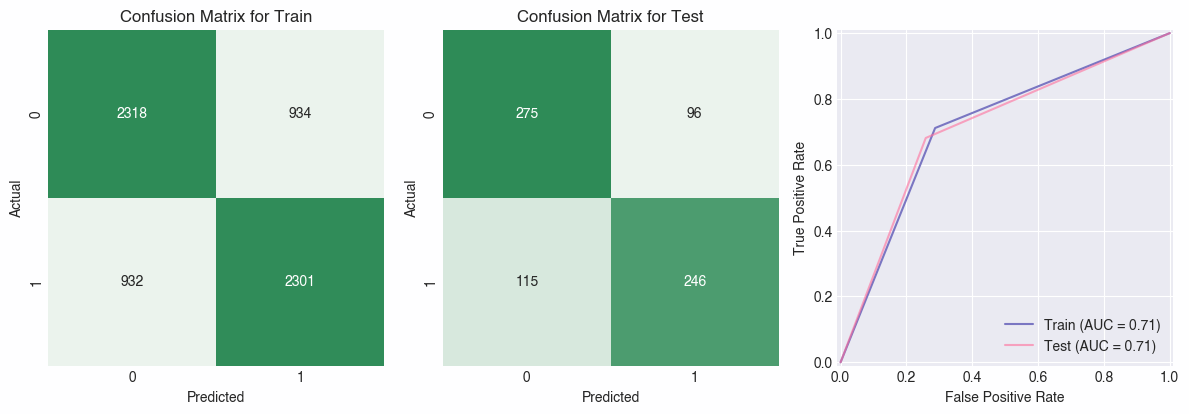

In [10]:
# predict & proba
pred_test = finalRF.predict(X_test[feat_RFECV])
proba_test = finalRF.predict_proba(X_test[feat_RFECV])

pred_train = finalRF.predict(X_train[feat_RFECV])
proba_train = finalRF.predict_proba(X_train[feat_RFECV])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

/Users/azabicki/miniconda3/envs/nf_CAPSTONE/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


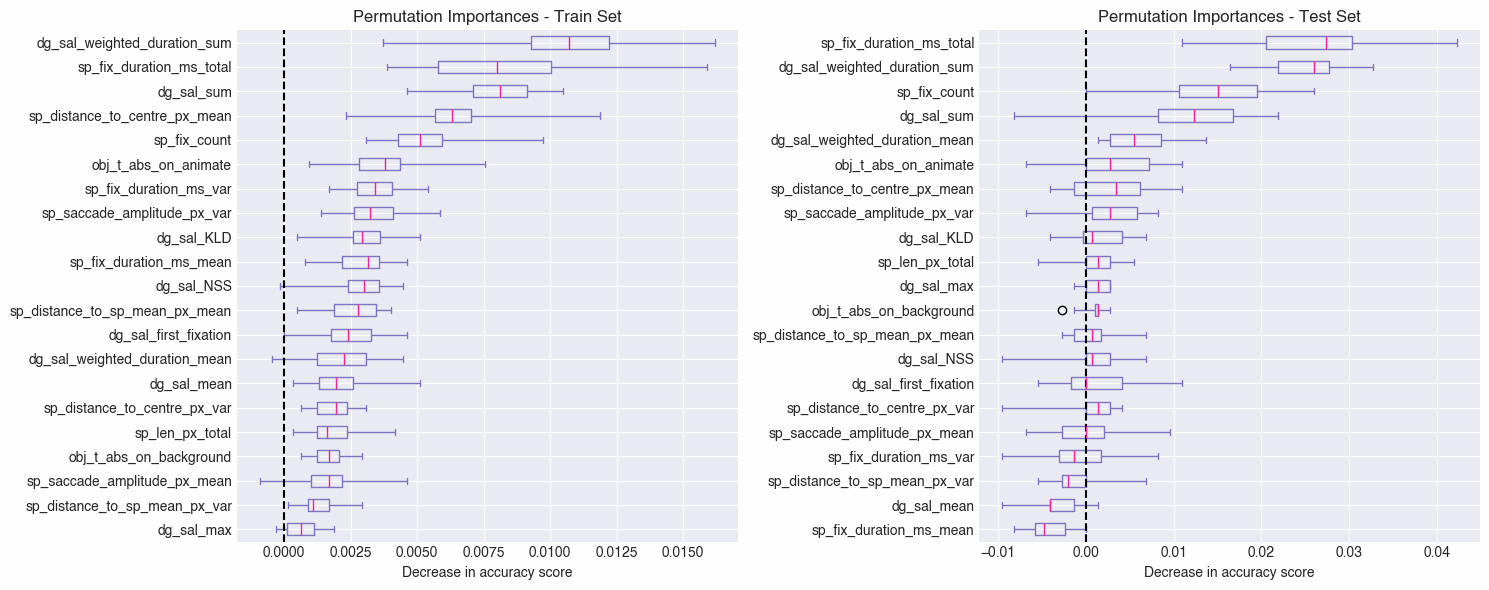

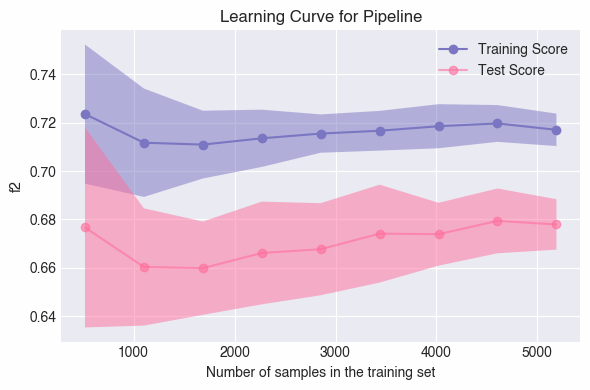

In [11]:
# Get the best parameters and best estimator
em.model_info(finalRF)

# feature importances
em.feat_importance(finalRF, X_train[feat_RFECV], y_train, X_test[feat_RFECV], y_test)

# learning curves - for one model - f2 score
em.learning(finalRF, X_train[feat_RFECV], y_train)

----

## Error analysis


30it [00:25,  1.20it/s]


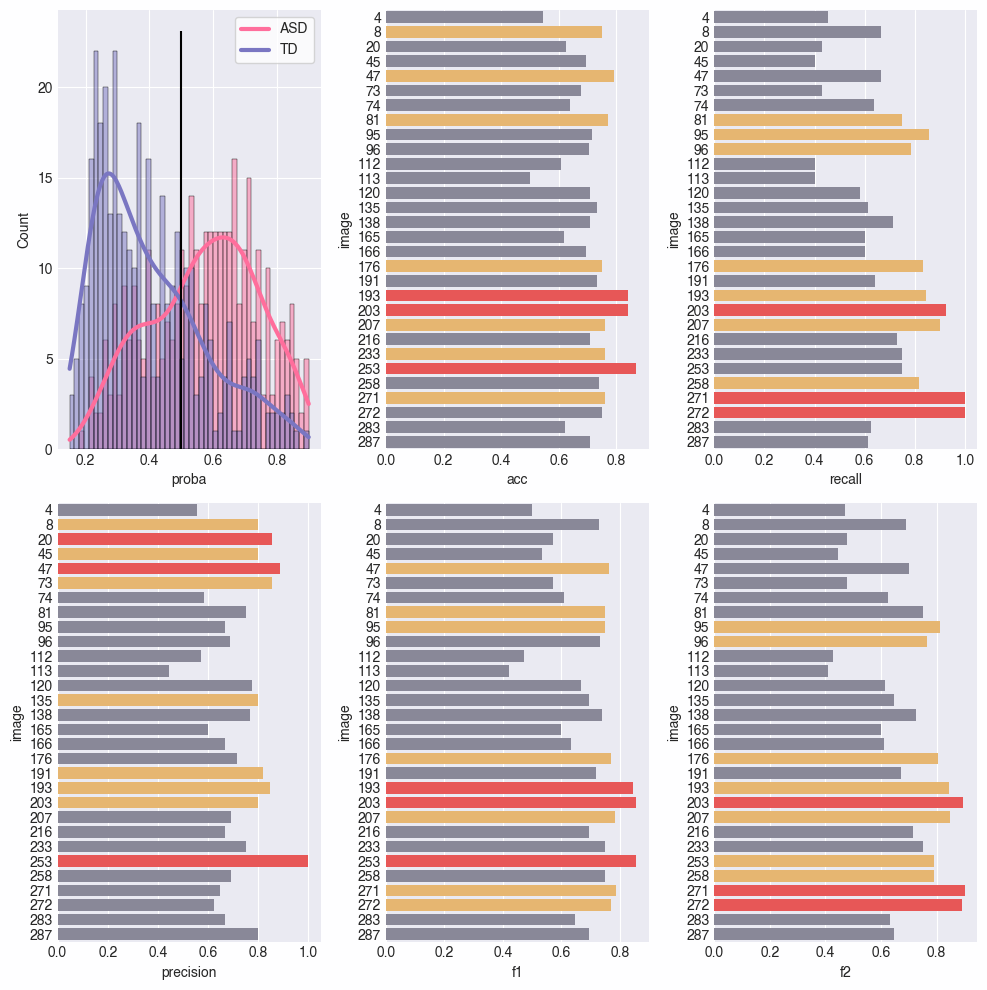

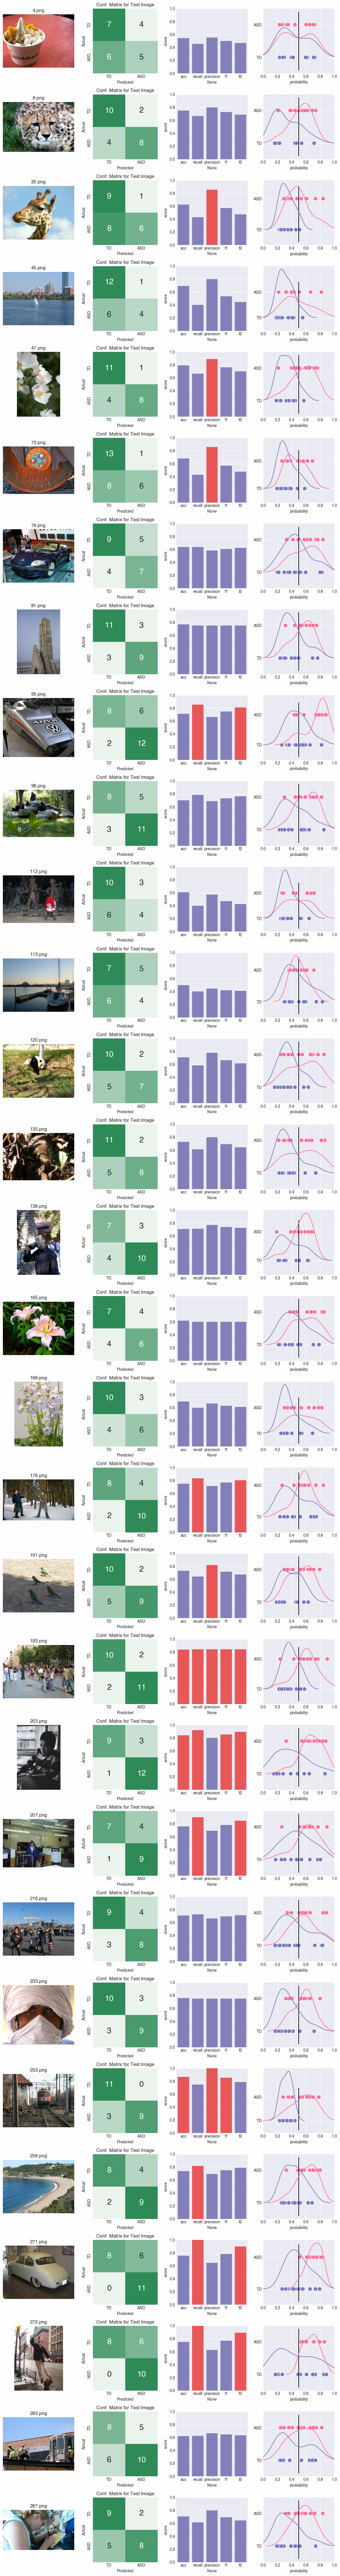

In [12]:
em.error_images(y_test, pred_test, proba_test=proba_test)